## Atlas preprocessing steps to convert MRI scans to atlas specific correlation matrices

This notebook contains the preprocessing steps to convert MRI scans to atlas specific correlation matrices. The steps are as follows:

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import nilearn
import pydicom as dicom

## DICOM to NIFTI conversion

First, if you have not already, you will need to have your images in NIFTI format (.nii or .nii.gz). You can convert the DICOM images (.dcm) to NIFTI either by:
- Using the dicom2nifti package as described below
- Using the dicom2niix package via cmd line (e.g. using : dcm2niix -f %p_%s -g y DIRECTORY_PATH)
- Using the dicom2bids package via cmd line (Recommended)

In [2]:
import dicom2nifti
directory_scan = 'RAW_PPMI/3102/ep2d_RESTING_STATE/2013-02-24_10_49_22.0/I378209/' # example of path of images of a scan
dicom2nifti.convert_directory(directory_scan, 'nifti_series', compression=True, reorient=True) # convert to nifti

## Atlas preprocessing
We are now ready to get the atlas parcellations for our NIFTI files

In [7]:
# Insert your path to the nifti file here (.nii or .nii.gz)
nifti_path = '/Users/yanis/Documents/Stanford/RESEARCH_FALL/RAW_PPMI/3102/ep2d_RESTING_STATE/2013-02-06_10_38_32.0/ep2d_RESTING_STATE_10.nii'

In [8]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

## CORTICAL ##
dataset = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm", symmetric_split=True)
atlas_filename = dataset.maps
labels = dataset.labels

masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
    labels=labels,
    resampling_target="labels",
)

time_series = masker.fit_transform(nifti_path)


## SUBCORTICAL ##
dataset_sub = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm", symmetric_split=False)
atlas_filename_sub = dataset_sub.maps
labels_sub = dataset_sub.labels

masker_sub = NiftiLabelsMasker(
    labels_img=atlas_filename_sub,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
    labels=labels_sub,
)

time_series_sub = masker_sub.fit_transform(nifti_path)

# Concatenate the two time series together
time_series_concat = np.concatenate((time_series, time_series_sub), axis=1)
print("Shape of time series for the cortical atlas: ", time_series.shape) # Expecting to be (n_time_points, 96)
print("Shape of time series for the subcortical atlas: ", time_series_sub.shape) # Expecting to be (n_time_points, 21)
print("Shape of time series for the cortical and subcortical atlas: ", time_series_concat.shape) # Expecting to be (n_time_points, 117)

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[Memory]0.0s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]0.1s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Shape of time series for the cortical atlas:  (210, 96)
Shape of time series for the subcortical atlas:  (210, 21)
Shape of time series for the cortical and subcortical atlas:  (210, 117)


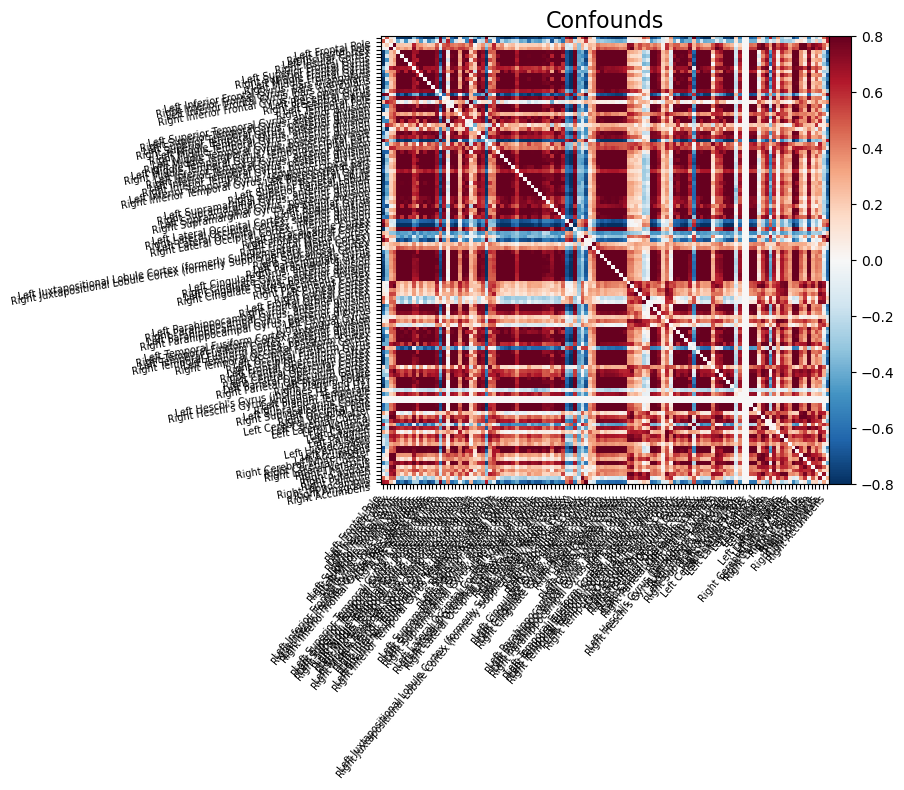

In [9]:
from nilearn.connectome import ConnectivityMeasure

# Compute correlation matrices
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series_concat])[0]

# Get correlation matrix for cortical atlas only
correlation_measure_cortical = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix_cortical = correlation_measure_cortical.fit_transform([time_series])[0]

# Plot the correlation matrix
from nilearn import plotting
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the first label
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    vmax=0.8,
    vmin=-0.8,
    title="Confounds",
    labels=labels[1:] + labels_sub[1:],
)

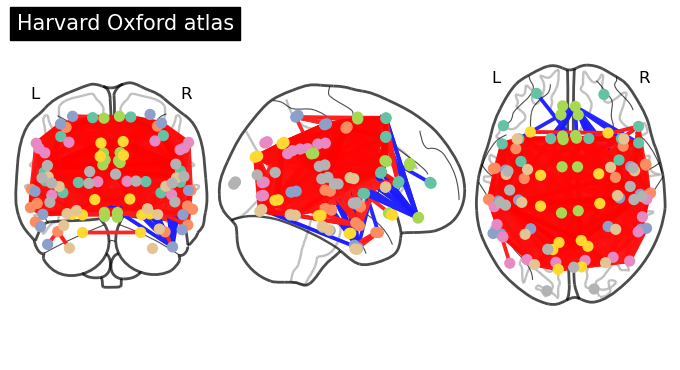

In [10]:
# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
plotting.plot_connectome(
    correlation_matrix_cortical,
    coordinates,
    edge_threshold="80%",
    title="Harvard Oxford atlas",
)

## AAL Atlas

In [11]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

## CORTICAL ##
dataset = datasets.fetch_atlas_aal()
atlas_filename = dataset.maps
labels = dataset.labels

masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
    labels=labels,
)

time_series = masker.fit_transform(nifti_path)

print("Shape of time series for the atlas: ", time_series.shape) # Expecting to be (n_time_points, 96)

[NiftiLabelsMasker.wrapped] loading data from /Users/yanis/nilearn_data/aal_SPM12/aal/atlas/AAL.nii
Resampling labels
[Memory]0.2s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
Shape of time series for the atlas:  (210, 115)


/opt/anaconda3/envs/cns/lib/python3.11/site-packages/nilearn/maskers/nifti_labels_masker.py:554: UserWarning: After resampling the label image to the data image, the following labels were removed: {6401}. Label image only contains 116 labels (including background).
  warnings.warn("After resampling the label image to the "


In [12]:
len(labels)

116

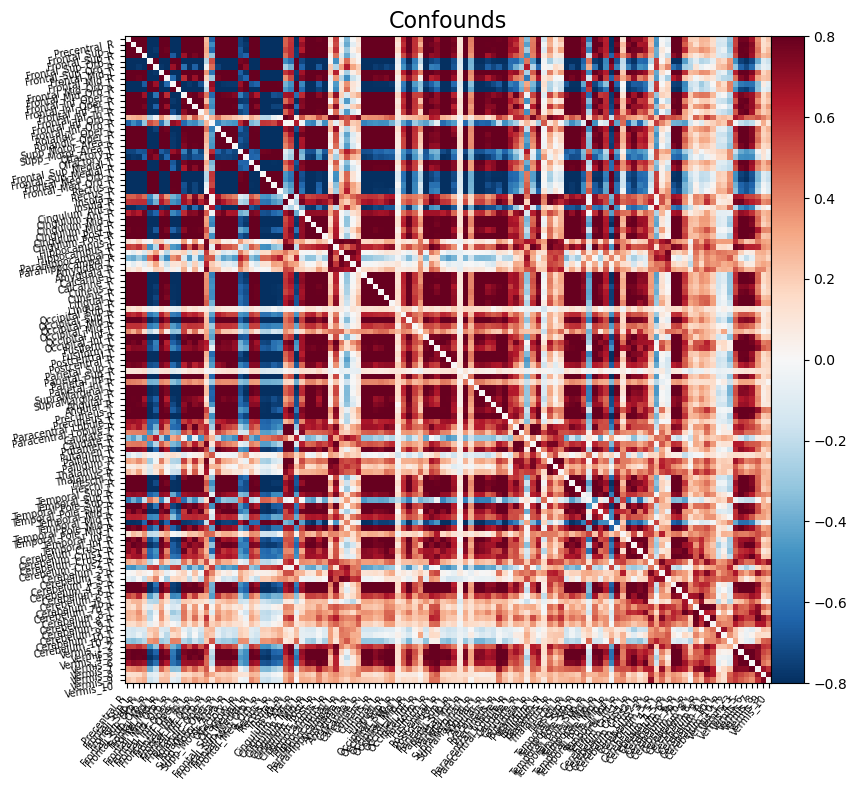

In [13]:
from nilearn.connectome import ConnectivityMeasure

# Compute correlation matrices
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix
from nilearn import plotting
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the first label
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    vmax=0.8,
    vmin=-0.8,
    title="Confounds",
    labels=labels[1:],
)

In [14]:
coordinates.shape

(96, 3)

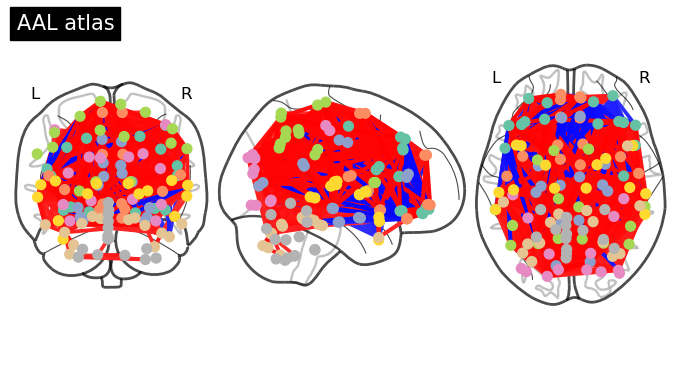

In [15]:
# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
plotting.plot_connectome(
    correlation_matrix,
    coordinates[1:],
    edge_threshold="80%",
    title="AAL atlas",
)

## DIFUMO Atlas

In [2]:
# Insert your path to the nifti file here (.nii or .nii.gz)
nifti_path = '/Users/yanis/Downloads/func_preproc/Caltech_0051456_func_preproc.nii.gz'

In [3]:
import os 
import json 
import nibabel as nb

def get_bold_tr(bold_path):
    json_sidecar_path = '{}.json'.format(
        bold_path.split('.nii.gz')[0]
    )
    if os.path.isfile(json_sidecar_path):
        with open(json_sidecar_path, 'r') as jfile:
            jdata=jfile.read()
        t_r = json.loads(jdata)['RepetitionTime']
    else:
        t_r = nb.load(bold_path).header.get_zooms()[-1]
    return round(float(t_r), 5)

In [4]:
t_r = get_bold_tr(nifti_path)

In [9]:
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker

dataset = datasets.fetch_atlas_difumo(
                dimension=1024,
                resolution_mm=2
            )
atlas_maps = dataset.maps
labels = dataset.labels

masker = NiftiMapsMasker(
    maps_img=atlas_maps,
    smoothing_fwhm=3,
    standardize="zscore",
    detrend=True,
    memory="nilearn_cache",
    verbose=5,
    high_pass=0.008,
    t_r=t_r,
)

#time_series = masker.fit_transform(nifti_path)
#print("Shape of time series for the atlas: ", time_series.shape) # Expecting to be (n_time_points, 1024)

/opt/anaconda3/envs/cns/lib/python3.11/site-packages/nilearn/datasets/atlas.py:142: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


In [ ]:
time_series.shape

In [ ]:
from nilearn.connectome import ConnectivityMeasure

# Compute correlation matrices
correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]


In [18]:
print(correlation_matrix.shape)
correlation_matrix

(1024, 1024)


array([[ 1.        ,  0.26334624,  0.35019931, ...,  0.19507718,
         0.11943249,  0.03061217],
       [ 0.26334624,  1.        ,  0.03302392, ..., -0.0080034 ,
         0.17019328, -0.00667153],
       [ 0.35019931,  0.03302392,  1.        , ...,  0.25819722,
        -0.1475062 , -0.03676249],
       ...,
       [ 0.19507718, -0.0080034 ,  0.25819722, ...,  1.        ,
        -0.25483309, -0.11441665],
       [ 0.11943249,  0.17019328, -0.1475062 , ..., -0.25483309,
         1.        ,  0.21140446],
       [ 0.03061217, -0.00667153, -0.03676249, ..., -0.11441665,
         0.21140446,  1.        ]])

In [12]:
# get all files in the directory "/Users/yanis/Downloads/func_preproc/"
import os
directory = "/Users/yanis/Downloads/func_preproc/"
nifti_paths = []
for filename in os.listdir(directory):
    if filename.endswith(".nii.gz"):
        nifti_path = os.path.join(directory, filename)
        nifti_paths.append(nifti_path)
print(len(nifti_paths))

1100


In [13]:
from tqdm.notebook import tqdm
import os 

directory = "/Users/yanis/Downloads/func_preproc/"
nifti_paths = []
for filename in os.listdir(directory):
    if filename.endswith(".nii.gz"):
        nifti_path = os.path.join(directory, filename)
        nifti_paths.append(nifti_path)
print(len(nifti_paths))

store_matrix = {}
for nifti_path in tqdm(nifti_paths):
    t_r = get_bold_tr(nifti_path)
    time_series = masker.fit_transform(nifti_path)
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    store_matrix[nifti_path] = correlation_matrix

  0%|          | 0/1100 [00:00<?, ?it/s]

[NiftiMapsMasker.wrapped] loading regions from None
Resampling maps


/opt/anaconda3/envs/cns/lib/python3.11/site-packages/nilearn/_utils/cache_mixin.py:241: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn(


[Memory]12.7s, 0.2min   : Loading resample_img...
________________________________________resample_img cache loaded - 0.4s, 0.0min
[Memory]15.2s, 0.3min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from None
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract('/Users/yanis/Downloads/func_preproc/SDSU_0050184_func_preproc.nii.gz', <nilearn.maskers.nifti_maps_masker._ExtractionFunctor object at 0x1852921d0>, { 'allow_overlap': True,
  'clean_kwargs': {},
  'detrend': True,
  'dtype': None,
  'high_pass': 0.008,
  'high_variance_confounds': False,
  'keep_masked_maps': True,
  'low_pass': None,
  'maps_img': '/Users/yanis/nilearn_data/difumo_atlases/1024/2mm/maps.nii.gz',
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': 3,
  'standardize': 'zscore',
  '

/opt/anaconda3/envs/cns/lib/python3.11/site-packages/joblib/memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)
/opt/anaconda3/envs/cns/lib/python3.11/site-packages/nilearn/maskers/nifti_maps_masker.py:584: UserWarning: Persisting input arguments took 4.15s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  region_signals, labels_ = self._cache(


______________________________________________filter_and_extract - 50.9s, 0.8min
[NiftiMapsMasker.wrapped] loading regions from None
[Memory]158.8s, 2.6min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from None
[Memory]206.5s, 3.4min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from None
[Memory]254.8s, 4.2min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from None
[Memory]301.1s, 5.0min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.wrapped] loading regions from None
[Memory]349.3s, 5.8min  : Loading _filter_and_extract...
__________________________________filter_and_extra